In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Step 1. Create your own dataset featuring 3 custom categories of at least 100 images each

I've used a python script to crawl data from google images. The .ipynb file for that is submitted along with the custom dataset.

In [3]:
data_dir="/content/drive/My Drive/dataset"

## Step 2: Split this data between 80% training and 20% test

## Step 3. Preprocess the data as you see fit

1. changing image height and width to 128x128
2. Rescaling values between 0 and 1

In [7]:
batch_size = 32
img_height = 128
img_width = 128

In [8]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=13,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 335 files belonging to 3 classes.
Using 268 files for training.


In [9]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=13,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 335 files belonging to 3 classes.
Using 67 files for validation.


### Class Names

In [10]:
class_names = train_ds.class_names
print(class_names)

['car', 'dogs', 'table']


### Visualize the data


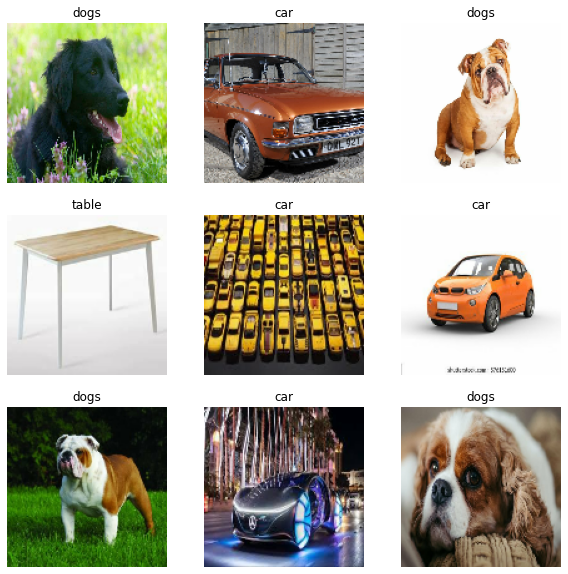

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [12]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 128, 128, 3)
(32,)


### AutoTune

In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(350).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Data augmentation (To avoid Overfitting)

In [16]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

## Step 4. Create a Convolutional Neural Network based model to learn on your training set 

In [17]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.3),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.3),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.3),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(3)
])

In [18]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [19]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 128, 128, 3)       0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)       

In [20]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True)

In [21]:
epochs=100
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[es]
)

Epoch 1/100
9/9 [==============================] - 4s 161ms/step - loss: 3.3897 - accuracy: 0.3731 - val_loss: 1.0969 - val_accuracy: 0.3284
Epoch 2/100
9/9 [==============================] - 0s 48ms/step - loss: 1.0917 - accuracy: 0.4179 - val_loss: 1.0913 - val_accuracy: 0.3284
Epoch 3/100
9/9 [==============================] - 0s 47ms/step - loss: 1.0193 - accuracy: 0.5149 - val_loss: 0.9786 - val_accuracy: 0.6716
Epoch 4/100
9/9 [==============================] - 0s 49ms/step - loss: 0.7921 - accuracy: 0.6455 - val_loss: 0.8713 - val_accuracy: 0.6269
Epoch 5/100
9/9 [==============================] - 0s 46ms/step - loss: 0.6837 - accuracy: 0.6754 - val_loss: 0.7996 - val_accuracy: 0.5970
Epoch 6/100
9/9 [==============================] - 0s 46ms/step - loss: 0.6651 - accuracy: 0.7313 - val_loss: 1.0829 - val_accuracy: 0.5373
Epoch 7/100
9/9 [==============================] - 0s 47ms/step - loss: 0.6126 - accuracy: 0.7575 - val_loss: 0.9797 - val_accuracy: 0.6269
Epoch 8/100
9/9 [==

## Step 5. Make predictions on the test data and compare them to the expected categories

### 1. Using Tensorflow dataset and model.evaluate 

In [45]:
train_loss, train_acc = model.evaluate(x_train, y_train, verbose=2)

1/1 - 0s - loss: 0.2638 - accuracy: 0.9062


In [67]:
val_loss, val_acc = model.evaluate(val_ds, verbose=2)

3/3 - 0s - loss: 0.6117 - accuracy: 0.8209


### 2. Using traditional method

In [63]:
predictions = np.array([])
labels =  np.array([])
for x, y in val_ds:
  predictions = np.concatenate([predictions, np.argmax(model.predict(x), axis = 1)])
  labels = np.concatenate([labels, y.numpy()])

In [66]:
accuracy_score(labels, predictions)

0.8208955223880597

### Testing on fresh data 

In [30]:
dog_url = "https://upload.wikimedia.org/wikipedia/commons/4/47/American_Eskimo_Dog.jpg"
dog_path = tf.keras.utils.get_file('dog_sample', origin=sunflower_url)

img = keras.preprocessing.image.load_img(
    dog_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) 

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to dogs with a 83.72 percent confidence.
